# ⚡ Entrenamiento de Modelo LightGBM - PAKDD 2010 Credit Risk

Este notebook entrena y evalúa un modelo de clasificación usando LightGBM
sobre los datos preprocesados generados en `02_Preprocessing.ipynb`.

---

## 🎯 Objetivos:
- Cargar los splits procesados (`X_train`, `X_test`, `y_train`, `y_test`)
- Aplicar el pipeline de preprocesamiento
- Entrenar un modelo base LightGBM
- Evaluar desempeño (ROC-AUC, accuracy, f1-score, matriz de confusión)
- Analizar importancia de variables
- (Opcional) Ajustar hiperparámetros con RandomizedSearchCV


### 📚 Importar Librerías

In [2]:
import sys
import os
# Agrega la carpeta raíz del proyecto (una arriba de notebooks/)
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import pandas as pd
import numpy as np
import joblib
from datetime import datetime
from lightgbm import LGBMClassifier # sklearn API
import lightgbm as lgb  # native API for focal loss

from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report
)
from sklearn.model_selection import RandomizedSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight

print("✅ Librerías importadas correctamente.")

✅ Librerías importadas correctamente.


## 📁 Cargar Splits Procesados

In [3]:
DATA_DIR = "../data/processed/"
MODEL_DIR = "../models/"
TARGET_COL = "TARGET_LABEL_BAD=1"

print("📥 Cargando datasets de entrenamiento y prueba...")

X_train = pd.read_parquet(os.path.join(DATA_DIR, "X_train.parquet"))
X_test  = pd.read_parquet(os.path.join(DATA_DIR, "X_test.parquet"))
y_train = pd.read_parquet(os.path.join(DATA_DIR, "y_train.parquet"))[TARGET_COL]
y_test  = pd.read_parquet(os.path.join(DATA_DIR, "y_test.parquet"))[TARGET_COL]

print(f"✅ X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"✅ y_train: {y_train.shape}, y_test: {y_test.shape}")

📥 Cargando datasets de entrenamiento y prueba...
✅ X_train: (40000, 53), X_test: (10000, 53)
✅ y_train: (40000,), y_test: (10000,)


## 🧩 Cargar y Aplicar el Pipeline Entrenado

In [4]:
import sys
import os
# Asegura que Python pueda encontrar el módulo 'src'

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
print("⚙️ Cargando pipeline entrenado...")

PIPELINE_PATH = os.path.join(MODEL_DIR, "preprocessing_pipeline.joblib")
pipeline = joblib.load(PIPELINE_PATH)

print("🚀 Aplicando pipeline a los datos...")

X_train_processed = pipeline.transform(X_train)
X_test_processed  = pipeline.transform(X_test)

print(f"✅ Transformaciones aplicadas.")
print(f"📏 Train transformado: {X_train_processed.shape}")
print(f"📏 Test transformado:  {X_test_processed.shape}")

⚙️ Cargando pipeline entrenado...
🚀 Aplicando pipeline a los datos...
✅ Transformaciones aplicadas.
📏 Train transformado: (40000, 151)
📏 Test transformado:  (10000, 151)


## ⚡ Entrenar Modelo LightGBM Base

In [5]:
from src.models.train_model import train_lightgbm
print("🚀 Entrenando el modelo LightGBM...")

model = train_lightgbm(X_train, y_train, X_test, y_test)


print("✅ Modelo entrenado con éxito.")

🚀 Entrenando el modelo LightGBM...
[LightGBM] [Info] Number of positive: 10433, number of negative: 29567
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004613 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2503
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 147
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.260825 -> initscore=-1.041685
[LightGBM] [Info] Start training from score -1.041685
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
ROC-AUC: 0.6448
Entrenamiento completado. El guardado se realiza desde el notebook.
✅ Modelo entrenado con éxito.


c:\AnyoneIA\ML_CreditRisk\venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


## 📈 Evaluar Modelo

In [6]:
print("📊 Evaluando desempeño...")

y_pred = model.predict(X_test_processed)
y_pred_proba = model.predict_proba(X_test_processed)[:, 1]

roc = roc_auc_score(y_test, y_pred_proba)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"🏁 ROC-AUC: {roc:.4f}")
print(f"✅ Accuracy: {acc:.4f}")
print(f"🎯 F1-Score: {f1:.4f}")

print("\n🔢 Reporte de Clasificación:")
print(classification_report(y_test, y_pred, digits=3))

📊 Evaluando desempeño...
🏁 ROC-AUC: 0.6448
✅ Accuracy: 0.7412
🎯 F1-Score: 0.0983

🔢 Reporte de Clasificación:
              precision    recall  f1-score   support

           0      0.747     0.984     0.849      7392
           1      0.538     0.054     0.098      2608

    accuracy                          0.741     10000
   macro avg      0.642     0.519     0.474     10000
weighted avg      0.692     0.741     0.653     10000



c:\AnyoneIA\ML_CreditRisk\venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\AnyoneIA\ML_CreditRisk\venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


## 🧮 Matriz de Confusión

c:\AnyoneIA\ML_CreditRisk\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


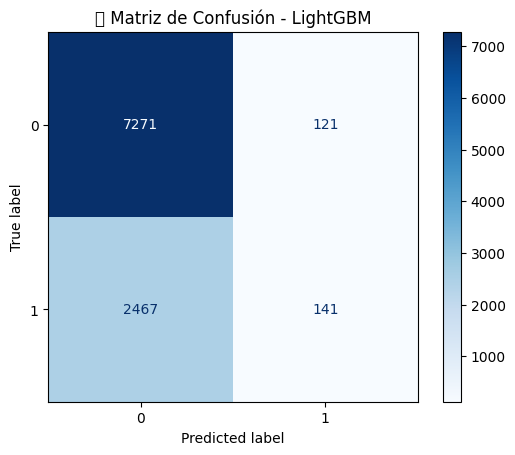

In [6]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format="d")
plt.title("📊 Matriz de Confusión - LightGBM")
plt.show()

## 🔍 Importancia de Variables

📊 Calculando importancia de variables...


C:\Users\ext83752\AppData\Local\Temp\ipykernel_27872\2132944185.py:16: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\AnyoneIA\ML_CreditRisk\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


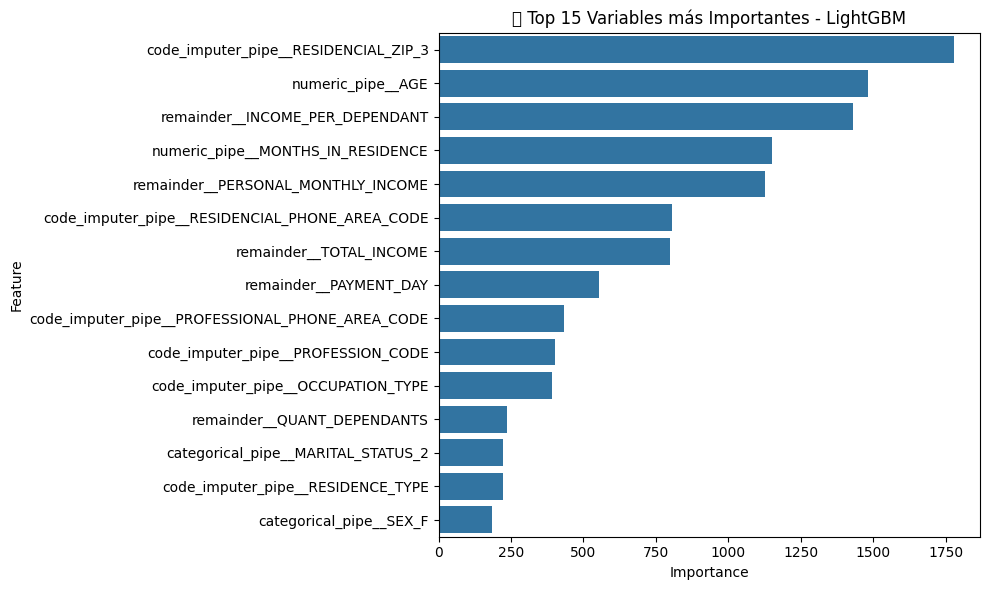

In [7]:
print("📊 Calculando importancia de variables...")

try:
    feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
except:
    feature_names = [f"feature_{i}" for i in range(X_train_processed.shape[1])]

importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances.head(15))
plt.title("🏆 Top 15 Variables más Importantes - LightGBM")
plt.tight_layout()
plt.show()

## 🧠 Optimización de Hiperparámetros con RandomizedSearchCV

In [20]:
print("🔍 Iniciando búsqueda de hiperparámetros (puede tardar varios minutos)...")

from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Calcular peso de clases
weight = y_train.value_counts()[0] / y_train.value_counts()[1]# ya no porque es agresivo

param_dist = {
    "num_leaves": [31, 63, 127, 255],
    "max_depth": [-1, 7, 9, 11],
    "learning_rate": [0.1, 0.05, 0.02, 0.01],
    "n_estimators": [400, 800, 1200],
    "min_child_samples": [5, 10, 20, 40],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "scale_pos_weight": [1.5, 2.0, 2.5, 3.0]
}

search = RandomizedSearchCV(
    estimator=LGBMClassifier(
        objective='binary',
        boosting_type='gbdt',
        random_state=42,
        n_jobs=-1
    ),
    param_distributions=param_dist,
    n_iter=25,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

search.fit(X_train_processed, y_train)

print("\n✅ Mejor configuración encontrada:")
print(search.best_params_)
print(f"📈 Mejor ROC-AUC (CV): {search.best_score_:.4f}")

best_model = search.best_estimator_

🔍 Iniciando búsqueda de hiperparámetros (puede tardar varios minutos)...
Fitting 3 folds for each of 25 candidates, totalling 75 fits
[LightGBM] [Info] Number of positive: 10433, number of negative: 29567
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2499
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 145
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.260825 -> initscore=-1.041685
[LightGBM] [Info] Start training from score -1.041685

✅ Mejor configuración encontrada:
{'subsample': 1.0, 'scale_pos_weight': 3.0, 'num_leaves': 31, 'n_estimators': 400, 'min_child_samples': 40, 'max_depth': -1, 'learning_rate': 0.02, 'colsample_bytree': 0.6}
📈 Mejor ROC-AUC (CV): 0.6417


In [8]:
print("📊 Evaluando desempeño (modelo optimizado)...")

y_pred = best_model.predict(X_test_processed)
y_pred_proba = best_model.predict_proba(X_test_processed)[:, 1]

roc = roc_auc_score(y_test, y_pred_proba)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"🏁 ROC-AUC: {roc:.4f}")
print(f"✅ Accuracy: {acc:.4f}")
print(f"🎯 F1-Score: {f1:.4f}")

print("\n🔢 Reporte de Clasificación:")
print(classification_report(y_test, y_pred, digits=3))

📊 Evaluando desempeño (modelo optimizado)...
🏁 ROC-AUC: 0.6487
✅ Accuracy: 0.5661
🎯 F1-Score: 0.4478

🔢 Reporte de Clasificación:
              precision    recall  f1-score   support

           0      0.821     0.528     0.643      7392
           1      0.335     0.674     0.448      2608

    accuracy                          0.566     10000
   macro avg      0.578     0.601     0.545     10000
weighted avg      0.695     0.566     0.592     10000



c:\AnyoneIA\ML_CreditRisk\venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\AnyoneIA\ML_CreditRisk\venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [22]:
model_load = joblib.load("../models/lightgbm_best_20251106_1222.pkl")

In [23]:
print("📊 Evaluando desempeño (modelo cargado)...")

y_pred = model_load.predict(X_test_processed)
y_pred_proba = model_load.predict_proba(X_test_processed)[:, 1]

roc = roc_auc_score(y_test, y_pred_proba)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"🏁 ROC-AUC: {roc:.4f}")
print(f"✅ Accuracy: {acc:.4f}")
print(f"🎯 F1-Score: {f1:.4f}")

print("\n🔢 Reporte de Clasificación:")
print(classification_report(y_test, y_pred, digits=3))

📊 Evaluando desempeño (modelo cargado)...
🏁 ROC-AUC: 0.6487
✅ Accuracy: 0.5661
🎯 F1-Score: 0.4478

🔢 Reporte de Clasificación:
              precision    recall  f1-score   support

           0      0.821     0.528     0.643      7392
           1      0.335     0.674     0.448      2608

    accuracy                          0.566     10000
   macro avg      0.578     0.601     0.545     10000
weighted avg      0.695     0.566     0.592     10000



c:\AnyoneIA\ML_CreditRisk\venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\AnyoneIA\ML_CreditRisk\venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


## SMOTE

In [24]:
print("🔄 Aplicando SMOTE para balancear clases...")

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

print(f"✅ Antes SMOTE: {y_train.value_counts().to_dict()}")
print(f"✅ Después SMOTE: {pd.Series(y_train_resampled).value_counts().to_dict()}")


🔄 Aplicando SMOTE para balancear clases...
✅ Antes SMOTE: {0: 29567, 1: 10433}
✅ Después SMOTE: {0: 29567, 1: 29567}


In [25]:
print("🔍 Iniciando búsqueda de hiperparámetros (puede tardar varios minutos)...")

from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Calcular peso de clases
# weight = y_train.value_counts()[0] / y_train.value_counts()[1]# ya no porque es agresivo

param_dist = {
    "num_leaves": [31, 63, 127, 255],
    "max_depth": [-1, 7, 9, 11],
    "learning_rate": [0.1, 0.05, 0.02, 0.01],
    "n_estimators": [400, 800, 1200],
    "min_child_samples": [5, 10, 20, 40],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "scale_pos_weight": [1.5, 2.0, 2.5, 3.0]
}

search = RandomizedSearchCV(
    estimator=LGBMClassifier(
        objective='binary',
        boosting_type='gbdt',
        random_state=42,
        n_jobs=-1
    ),
    param_distributions=param_dist,
    n_iter=25,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

search.fit(X_train_resampled, y_train_resampled)

print("\n✅ Mejor configuración encontrada:")
print(search.best_params_)
print(f"📈 Mejor ROC-AUC (CV): {search.best_score_:.4f}")

best_model_smote = search.best_estimator_

🔍 Iniciando búsqueda de hiperparámetros (puede tardar varios minutos)...
Fitting 3 folds for each of 25 candidates, totalling 75 fits
[LightGBM] [Info] Number of positive: 29567, number of negative: 29567
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30664
[LightGBM] [Info] Number of data points in the train set: 59134, number of used features: 147
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

In [28]:
print("📊 Evaluando desempeño con smote...")

y_pred = best_model_smote.predict(X_test_processed)
y_pred_proba = best_model_smote.predict_proba(X_test_processed)[:, 1]

roc = roc_auc_score(y_test, y_pred_proba)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"🏁 ROC-AUC: {roc:.4f}")
print(f"✅ Accuracy: {acc:.4f}")
print(f"🎯 F1-Score: {f1:.4f}")

print("\n🔢 Reporte de Clasificación:")
print(classification_report(y_test, y_pred, digits=3))

📊 Evaluando desempeño con smote...


c:\AnyoneIA\ML_CreditRisk\venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\AnyoneIA\ML_CreditRisk\venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


🏁 ROC-AUC: 0.6388
✅ Accuracy: 0.7000
🎯 F1-Score: 0.3658

🔢 Reporte de Clasificación:
              precision    recall  f1-score   support

           0      0.779     0.830     0.804      7392
           1      0.408     0.332     0.366      2608

    accuracy                          0.700     10000
   macro avg      0.593     0.581     0.585     10000
weighted avg      0.682     0.700     0.689     10000



In [29]:
from sklearn.metrics import precision_recall_curve, f1_score, classification_report

# Probabilidades del modelo SMOTE
proba = best_model_smote.predict_proba(X_test_processed)[:, 1]

# Curva Precision-Recall para buscar threshold óptimo
prec, rec, th = precision_recall_curve(y_test, proba)
f1s = 2 * (prec * rec) / (prec + rec + 1e-9)  # evitar division por cero

best_idx = f1s.argmax()
best_thr = th[best_idx]

print(f"⭐ Mejor threshold para F1: {best_thr:.3f}")
print(f"📈 Mejor F1: {f1s[best_idx]:.4f}")
print(f"🎯 Precision: {prec[best_idx]:.4f}, Recall: {rec[best_idx]:.4f}")

# Aplicar el threshold óptimo
y_pred_opt = (proba >= best_thr).astype(int)

print("\n🔢 Reporte con threshold ajustado:")
print(classification_report(y_test, y_pred_opt, digits=3))

c:\AnyoneIA\ML_CreditRisk\venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


⭐ Mejor threshold para F1: 0.346
📈 Mejor F1: 0.4506
🎯 Precision: 0.3209, Recall: 0.7561

🔢 Reporte con threshold ajustado:
              precision    recall  f1-score   support

           0      0.835     0.435     0.572      7392
           1      0.321     0.756     0.451      2608

    accuracy                          0.519     10000
   macro avg      0.578     0.596     0.512     10000
weighted avg      0.701     0.519     0.541     10000



## 💾 Guardar Modelo Entrenado

In [ ]:
model_path = f"../models/lightgbm_best_{datetime.now().strftime('%Y%m%d_%H%M')}.pkl"
joblib.dump(best_model, model_path)
print(f"💾  Modelo optimizado guardado en: {model_path}")

💾  Modelo optimizado guardado en: ../models/lightgbm_best_smote_20251106_1241.pkl


In [ ]:
# os.makedirs(MODEL_DIR, exist_ok=True)
# model_path = os.path.join(
#     MODEL_DIR, f"lightgbm_model_{datetime.now().strftime('%Y%m%d_%H%M')}.pkl"
# )

# joblib.dump(model, model_path)
# print(f"💾 Modelo guardado en: {model_path}")

## 📝 Logs finales

In [ ]:
print("="*70)
print("🏁 ENTRENAMIENTO COMPLETO")
print(f"📅 Fecha: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"📊 Train (preprocesado): {X_train_processed.shape}")
print(f"🎯 ROC-AUC final: {roc:.4f}")
print(f"🎯 Accuracy final: {acc:.4f}")
print("="*70)